In [1]:
import pandas as pd
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import unicodedata
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tqdm import tqdm
from pickle import dump, load
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [2]:
stock_tweets = pd.read_csv('./data/stock_tweets.csv')

In [3]:
stock_tweets.shape

(80793, 4)

In [4]:
stock_tweets.head()

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [5]:
df = stock_tweets[stock_tweets['Stock Name']=='TSLA']

In [6]:
df.shape

(37422, 4)

In [7]:
nltk.download('vader_lexicon')
sentiment_df = df.copy()
sentiment_df["sentiment_score"] = ''
sentiment_df["Negative"] = ''
sentiment_df["Neutral"] = ''
sentiment_df["Positive"] = ''
sentiment_analyzer = SentimentIntensityAnalyzer()
for indx, row in sentiment_df.T.items():
    # Normalize the tweet text
    sentence_i = unicodedata.normalize('NFKD', sentiment_df.loc[indx, 'Tweet'])

    sentence_sentiment = sentiment_analyzer.polarity_scores(sentence_i)
    sentiment_df.at[indx, 'sentiment_score'] = sentence_sentiment['compound']
    sentiment_df.at[indx, 'Negative'] = sentence_sentiment['neg']
    sentiment_df.at[indx, 'Neutral'] = sentence_sentiment['neu']
    sentiment_df.at[indx, 'Positive'] = sentence_sentiment['pos']


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\weju\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [8]:
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])
sentiment_df['Date'] = sentiment_df['Date'].dt.date
sentiment_df = sentiment_df.drop(columns=['Stock Name', 'Company Name'])
min_date = sentiment_df['Date'].min()
max_date = sentiment_df['Date'].max()
print(min_date)
print(max_date)

2021-09-30
2022-09-29


Calculate mean of sentiment score on each day 

In [9]:
sentiment_mean_df = sentiment_df.drop(columns=['Tweet'])
sentiment_mean_df = sentiment_mean_df.groupby([sentiment_mean_df['Date']]).mean()

In [10]:
sentiment_mean_df.shape

(365, 4)

In [11]:
stocks = pd.read_csv('./data/stock_yfinance_data.csv')
stocks.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


In [12]:
tsla_df = stocks[stocks['Stock Name'] == "TSLA"]
tsla_df['Date'] = pd.to_datetime(tsla_df['Date'])
tsla_df['Date'] = tsla_df['Date'].dt.date
min_date = tsla_df['Date'].min()
max_date = tsla_df['Date'].max()
print(min_date)
print(max_date)

2021-09-30
2022-09-29


In [13]:
final_df = tsla_df.join(sentiment_mean_df, how="left", on="Date")
final_df = final_df.drop(columns=['Stock Name'])

In [14]:
final_df.drop(columns = ['Negative', 'Neutral', 'Positive'], inplace = True)

In [15]:
final_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,sentiment_score
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,0.231552
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,0.233704
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,0.135388
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,0.069445
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,0.19994


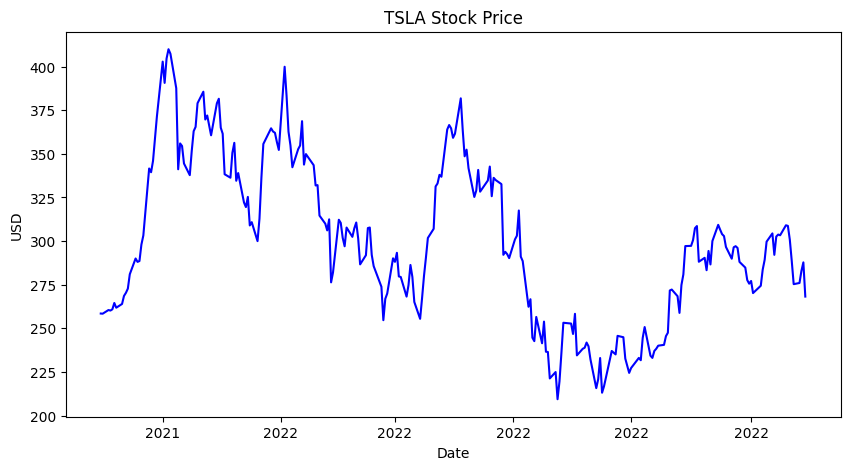

In [16]:
from general_utils import plot_stock_price
stock_name = 'TSLA'
plot_stock_price(final_df, stock_name)

In [17]:
final_df['Date'] = pd.to_datetime(final_df['Date'])
final_df = final_df.set_index('Date').sort_index()

Test RMSE:  7.449103861743119
Test MSE: 55.48914834303624
Test MAE: 5.327833404541002


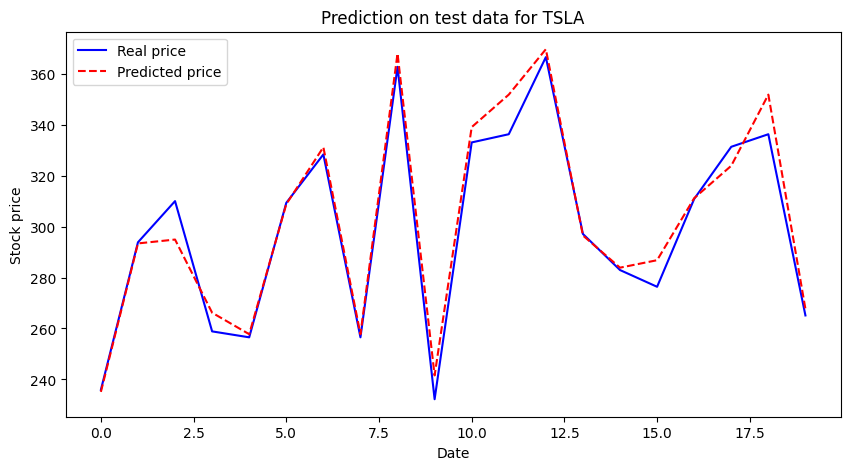

In [18]:
from general_utils import batch_data, normalize_data, split_train_test, predict_index, plot_results

X_scale_dataset, y_scale_dataset = normalize_data(final_df, (-1,1), "Close")
X_train, X_test, y_train, y_test = train_test_split(X_scale_dataset, y_scale_dataset, test_size=0.3, random_state=42)

# KNN model
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

knn_predictions = knn.predict(X_test)
plot_results(y_test, knn_predictions, stock_name)

In [19]:
X_batched, y_batched, yc = batch_data(X_scale_dataset, y_scale_dataset, batch_size = 5, predict_period = 1)

X_train, X_test, = split_train_test(X_batched)
y_train, y_test, = split_train_test(y_batched)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(final_df, X_train, 5, 1)

In [20]:
@tf.function 
def eval_op(generator, real_x):
    generated_data = generator(real_x, training = False)

    return generated_data

In [21]:
from model_gan_utils import make_generator_model, make_discriminator_model, train
from general_utils import plot_test_data

learning_rate = 5e-4
epochs = 500

input_dim = X_train.shape[1] 
feature_size = X_train.shape[2] 
output_dim = y_train.shape[1]

# GAN model
g_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
d_optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

generator = make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
discriminator = make_discriminator_model(X_train.shape[1])

 10%|████████▎                                                                        | 51/500 [00:24<01:36,  4.65it/s]

epoch 50 discriminator_loss 1.3908784 generator_loss 0.67617786


 20%|████████████████▏                                                               | 101/500 [00:33<01:25,  4.64it/s]

epoch 100 discriminator_loss 1.3865551 generator_loss 0.6927126


 30%|████████████████████████▏                                                       | 151/500 [00:42<01:16,  4.56it/s]

epoch 150 discriminator_loss 1.3854184 generator_loss 0.6894368


 40%|████████████████████████████████                                                | 200/500 [00:51<01:11,  4.20it/s]

epoch 200 discriminator_loss 1.3755264 generator_loss 0.71852964


 50%|████████████████████████████████████████▏                                       | 251/500 [01:00<00:52,  4.72it/s]

epoch 250 discriminator_loss 1.387339 generator_loss 0.69120884


 60%|████████████████████████████████████████████████▏                               | 301/500 [01:09<00:43,  4.63it/s]

epoch 300 discriminator_loss 1.3987522 generator_loss 0.7037733


 70%|████████████████████████████████████████████████████████▏                       | 351/500 [01:18<00:31,  4.75it/s]

epoch 350 discriminator_loss 1.3983238 generator_loss 0.6976986


 80%|████████████████████████████████████████████████████████████████▏               | 401/500 [01:27<00:20,  4.79it/s]

epoch 400 discriminator_loss 1.386558 generator_loss 0.6918704


 90%|████████████████████████████████████████████████████████████████████████▏       | 451/500 [01:36<00:10,  4.63it/s]

epoch 450 discriminator_loss 1.3859224 generator_loss 0.6954352


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:44<00:00,  4.77it/s]

epoch 500 discriminator_loss 1.3853879 generator_loss 0.69001734


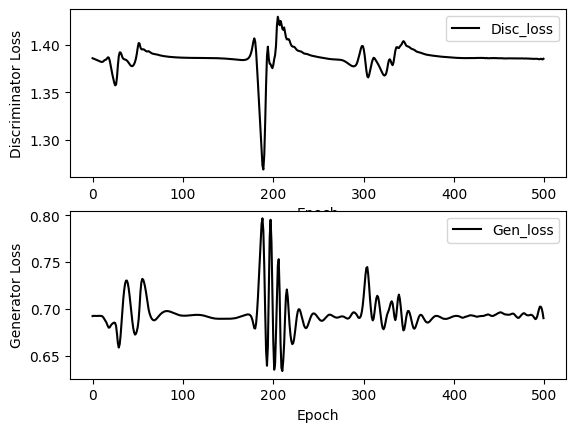

In [22]:

predicted_price, real_price, RMSPE = train(X_train, y_train, yc_train, epochs, generator, discriminator, g_optimizer, d_optimizer, stock_name)

In [23]:
test_generator = tf.keras.models.load_model(f'./models_gan/{stock_name}/generator_V_{epochs-1}.keras')

Test RMSE:  11.780752047304956


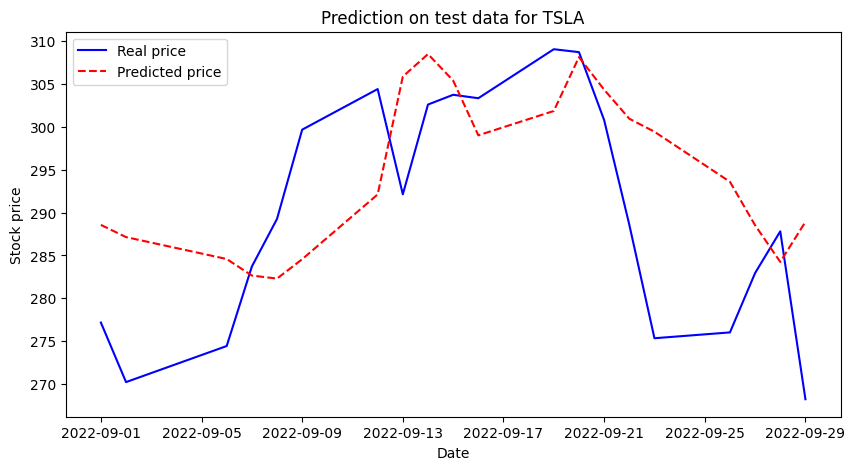

In [24]:
predicted_test_data = eval_op(test_generator, X_test)
plot_test_data(y_test, predicted_test_data, index_test, output_dim, stock_name)